# CS156 Week#7 Assignment - RBF & Yosemite Weather 
## Tomer Eldor
### Minerva Schools

* Credit: Thanking Yoel Ferdman who helped me work on this assignment, as I'm not feeling well and needed help.

## Revision Notes
* I used the RBF testing function to test on a higher range of RBFs and Sigmas. The whole range of tests took very long (over an hour, with re-running), which is why I didn't have time for it in the first iteration.
* (Un)surprisingly, our prediction's performance greatly improved with higher values, but not consistently. Generally, it reached a limit for each RBF such that increasing sigma over X (10 usually) didn't matter (I suspect it has to do with the shape of the data). 
* Overall, Lower numbers of RBF numbers worked better with higher widths of sigma, and vice versa. The winning combination from inspecting just orders of magnitude (RBFs from 1-1000, sigmas from 0.01-1000), was RBF of 1000 with sigma of UP TO 1. At sigma of 10 of higher, results deteriorated; mostly in the days and combined model. 
* I replaced R^2, which was just the suggested regr.score() of a Ridge Regression, with fitting the regression and testing performance both on training and on test sets, and measuring the MSE on each. 
* I attempted to Improve plotting of probabilities, especialy with surface in 3D, but in the final hour before submission it didn't work... I'm left with reverting to the previous version of plotting, while showing here the attempt and error in addition.

## Yosemite Village Yearly Weather
Temperature is cyclical, not only on a 24 hour basis but also on a yearly basis. Convert the dataset into a richer format whereby the day of the year is also captured. For example the time “20150212 1605”, can be converted into (43, 965) because the 12th of February is the 43rd day of the year, and 16:05 is the 965th minute of the day.


This data covers 6 years, so split the data into a training set of the first 5 years, and a testing set of the 6th year.


Using the temperature dataset from your pre-class work (https://course-resources.minerva.kgi.edu/uploaded_files/mke/rj3Edn/yosemite-temperatures.zip) 

In [2]:
# Setup: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

/Users/tomereldor/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


#### Fetching the Data

In [3]:
# creating a list of filenames
years = range(2011, 2017) #specifying range of years as variable
files = ['CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in years] #creating a list of file_names with the appropriate years

# loading the data from text. we are only interested in datetime, 
# which is divided into date in col 1 & hour/min in col 2, 
# and temperature in col 8. So we only grab columns 1,2,8. 
data = [np.loadtxt(f, usecols=[1, 2, 8, 9]) for f in files]
data = np.vstack(data)

## Converting into Pandas DF
df = pd.DataFrame(data)
#Renaming columns
df.rename(columns={0:'Date',1:'HHmm',2:'Temp', 3:'Rain'}, inplace=True)
df.head() #debug

,Date,HHmm,Temp,Rain
0,20110101.0,5.0,-6.4,0.0
1,20110101.0,10.0,-6.5,0.0
2,20110101.0,15.0,-6.5,0.0
3,20110101.0,20.0,-6.5,0.0
4,20110101.0,25.0,-6.7,0.0


In [4]:
## Data Sanity verification

## making sure data looks right, I checke for means, min , max, and values of data.
# print min(df.Temp),  max(df.Temp)
# print min(df.Rain),  max(df.Rain)
# len(df.Rain[df.Rain> -9999])
# len(df.Rain[df.Rain < -9998])

# There are some rows with corrupted values: 
# temperature of -9999 degress, or Rain of 
# these aren't informative and corrupted so I drop them.

len(df.Rain[df.Temp < -9998]) 
df = df[df.Temp > -9998.0] #removes bad data

len(df.Rain[df.Rain < -9998]) # 1862 rows only,  leaving 629434 rows
df = df[df.Rain > -9998.0] #eliminating those

#df.rename(columns={0:'Date',1:'HHmm',2:'Temp'}, inplace=True)
df_copy = df.copy()
df_copy.tail()

,Date,HHmm,Temp,Rain
631291,20161231.0,2340.0,0.3,0.0
631292,20161231.0,2345.0,0.2,0.0
631293,20161231.0,2350.0,0.0,0.0
631294,20161231.0,2355.0,-0.1,0.0
631295,20170101.0,0.0,-0.1,0.0


### Enriching to day and minute numerical format.
Temperature is cyclical, not only on a 24 hour basis but also on a yearly basis. 
Convert the dataset into a richer format whereby the day of the year is also captured. For example the time 20150212 1605, can be converted into (43, 965) because the 12th of February is the 43rd day of the year, and 16:05 is the 965th minute of the day.


In [5]:
'''Create converted Minutes column: from HHmm to continuous integer count of minutes from start of day.
This will convert to an int count of minutes from 0 to 1440 (num of minutes per day) in increments of 5 minutes.
Initially, keeping the HHmm column and Min column and compare for debugging'''

df['Min'] = np.floor_divide(df['HHmm'], 100) * 60 + np.mod(df['HHmm'], 100)

In [6]:
# converting dates to actual DateTime format from string
df['Date'] = pd.to_datetime(df['Date'], format = ('%Y%m%d'))
# from the datetime object, we can grab its components (year/month/day...)
df['Yr'] = df['Date'].dt.year # grabbing year
# Converting 'day' from date in date-time format to continuous integer count of days passed since Jan 1 that year
df['Day'] = df['Date'].dt.strftime('%j').astype(int)

# reordering columns
df = df[['Date','Yr','Day','Min','HHmm','Temp','Rain']]
df.tail()

,Date,Yr,Day,Min,HHmm,Temp,Rain
631291,2016-12-31,2016,366,1420.0,2340.0,0.3,0.0
631292,2016-12-31,2016,366,1425.0,2345.0,0.2,0.0
631293,2016-12-31,2016,366,1430.0,2350.0,0.0,0.0
631294,2016-12-31,2016,366,1435.0,2355.0,-0.1,0.0
631295,2017-01-01,2017,1,0.0,0.0,-0.1,0.0


*This data covers 6 years, so let's split the data into a training set of the first 5 years, and a testing set of the 6th year.*
The data covers from 2011 to 2016 and some of 2017.
I'll split it to test from 2011 to 2015, then test from 2016 onwards.
I'll be working with numpy onwards, so I'll convert needed columns into numpy arrays

In [7]:
# train set: before 2016 
train_data = df[df['Yr'] < 2016]  
# test set: 2016 or after 
test_data = df[df['Yr'] >= 2016]  

# Transformation from Pandas DF to Numpy Arrays 
train_data = train_data.values 
test_data = test_data.values 

In [8]:
# TRAINING and TEST Sets Split
# Since in Numpy I can't access columns by names, but I might change the DB structure whilt working on it,
# It's safer and simpler for me to make a dictionary of column names to their position and call using it
col_dict = {'date':0, 'year':1, 'yr':1, 'day':2, 'Day':2, 'min':3, 'Min':3, 'HHmm':4, 'temp':5}

# train sets
mins_train = np.array(train_data[:, col_dict['min']])
days_train = np.array(train_data[:, col_dict['day']])
temp_y_train = np.array(train_data[:, col_dict['temp']])

# test sets
mins_test = np.array(test_data[:,  col_dict['min']])
days_test = np.array(test_data[:, col_dict['day']])
temp_y_test = np.array(test_data[:, col_dict['temp']])


## Predictions

1. Cover each input dimension with a list of radial basis functions. This turns the pair of inputs into a much richer representation, mapping (d,t) into (Φ₁(d), Φ₂(t)). Experiment with different numbers of radial basis functions and different widths of the radial basis function in different dimensions.
2. Using this new representation, build a linear parameter model that captures both seasonal variations and daily variations.
3. Create two plots, one showing the time-of-day contribution, and one showing the time-of-year contribution.
4. Make a 3D plot showing temperature as a function of (day, time). Make sure to label your axes!
5. Using mean squared error, quantify how your model performs on the testing data if you:
    1. Train with just the daily component of the model
    2. Train with just the yearly component of the model
    3. Train with the full model.


### RBF

In [12]:
# Setup, Import RBF
from sklearn.metrics.pairwise import rbf_kernel 
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import  mean_squared_error

# We need to reshape the used np arrays (temp, min, day) to a column instead of a row
temp_y_train, temp_y_test = temp_y_train.reshape(-1,1), temp_y_test.reshape(-1,1)
all_minutes = df['Min'].values.reshape(-1,1)
all_days = df['Day'].values.reshape(-1,1)

# Function to initialize Centers list: dividing the range of chosen data into equal distances to start as RBF centers
def initialize_centers_list(minimum,maximum,n_rbf):
    centers = []
    # divide the range into equal distances to start as RBF centers
    if n_rbf==1:
        centers =[minimum,maximum]
    else:
        print("minimum: {}, maximum: {}, n_rbf: {}, steps= maximum/(n_rbf-1) : {} ".format(minimum,maximum,n_rbf,maximum/(n_rbf-1)))
        centers = [ i for i in range(minimum,maximum,maximum/(n_rbf-1)) ]
    # reshape from row to column
    centers = np.asarray((centers)).reshape(-1,1)
    return centers


def test_model_ridge(x_train,y_train,x_test,y_test,  alpha_ridge=0.001):
    ''' Function that will fit and predict using a Ridge regression 
        on the chosen data and report results of MSE and regression score (between y_true and y_predicted)'''
    # fitting the model and predicting using it
    regr = Ridge(alpha = alpha_ridge, fit_intercept=False) #choosing a classifier
    regr.fit(x_train,y_train) # fitting a Ridge Regression
    #predicting using the regression
    y_pred_train = regr.predict(x_train)
    y_pred_test = regr.predict(x_test) 
    
    # Calculating MSE of the model's prediction vs test y
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)
    
    # calculating scores of the model's prediction vs y 
    #score on training data
    #train_score = regr.score(y_pred_train,y_train)
    #score on test data
    #test_score = regr.score(y_pred_test,y_train)
    return mse_train, mse_test, y_pred_test

# print(test_model_ridge(X_train,temp_y_train)) #debug

def test_RBF(numbers_of_rbfs_to_test, widths_to_test):
    global df, all_minutes, all_days
    rbf_tests = []
    i=0
    for n_rbf in numbers_of_rbfs_to_test:
        for sigma in widths_to_test:
            i+=1
            
            #initializing a list for the RBF centers for minutes 
            #center_min = initialize_centers_list(0,1399,n_rbf)
            #initializing a list for the RBF centers for days 
            #center_days = initialize_centers_list(0,364,n_rbf)

            
            """ testing different centers setting""" 
            center_min = np.linspace(0, 1399, n_rbf).reshape(-1, 1)
            center_days = np.linspace(0, 366, n_rbf).reshape(-1, 1)
            
            
            ### Coverting each input dimension with a list of radial basis functions ###
            # The function rbf_kernel computes the radial basis function (RBF) kernel between two vectors X,Y: K(x, y) = exp(-gamma ||x-y||^2) 
            # (from http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html#sklearn.metrics.pairwise.rbf_kernel and the user guide)
            # Calculating RBF Kernels on the entier dataset, test+train
            minutes_rbf = rbf_kernel(all_minutes,center_min,gamma=1/sigma)
            days_rbf = rbf_kernel(all_days,center_days,gamma=1/sigma)
            
            ###  Split Data to Train and Test ###
            # find the row of first 2016 entry to split by
            split_id = np.where(np.logical_and(df.Date == '2016-01-01 00:00:00' , df.Min == 0.0))[0][0] # that's row 525479 apparently            
            # Splitting to test and train sets : either minutes or days
            X_mins_train, X_mins_test = minutes_rbf[:split_id], minutes_rbf[split_id:]
            X_days_train, X_days_test = days_rbf[:split_id], days_rbf[split_id:]
            # rebuilding X training/test set of both minutes and days together, by concatenating arrays togetehr as 2 columns
            X_train = np.concatenate((minutes_rbf[:split_id],days_rbf[:split_id]),axis=1)   
            X_test = np.concatenate((minutes_rbf[split_id:],days_rbf[split_id:]),axis=1)       

            print("Test {}: RBF centers={}, Sigma ={}, shape={}".format(i,n_rbf, sigma, len(X_train)))

            
            ### FITTING THE MODELS, TESTING AND REPORTING RESULTS ### 
            # "Building a linear parameter model regression that captures both seasonal variations and daily variations" 
            
            # Full Model (Minutes + Days): Fitting Regression, predicting and calculating performance MSE & R^2
            mse_full, train_mse_full,  y_pred_full = test_model_ridge(X_train,temp_y_train,X_test,temp_y_test, alpha_ridge=0.0001)
            
            # Only Minutes Model: Fitting Regression, predicting and calculating performance MSE & R^2
            mse_mins, train_mse_mins,  y_pred_mins = test_model_ridge(X_mins_train ,temp_y_train, X_mins_test, temp_y_test, alpha_ridge=0.0001)
            
            # Only Days Model: Fitting Regression, predicting and calculating performance MSE & R^2
            mse_days, train_mse_days, y_pred_days = test_model_ridge(X_days_train ,temp_y_train, X_days_test, temp_y_test, alpha_ridge=0.0001)
            
            # appending the results performance as a sublist into the list of performances
            rbf_tests.append([i,n_rbf, sigma, mse_full, train_mse_full, mse_mins, train_mse_mins, mse_days, train_mse_days])
            
    
    # transforming into DataFrame
    rbf_tests = pd.DataFrame(rbf_tests, columns = ["#","rbf centers","sigma","Full Model: Test MSE","Full Model: Train MSE","Minutes Mode: MSE", "Minutes Model: R^2","Days Model: MSE", "Days Model: R^2"])    
    #print('{}\n'.format(rbf_tests)) #debug
    return rbf_tests #,[X_mins_train, X_mins_test, X_days_train, X_days_test]
        
        
# Testing! insert lists of number of RBFs to test and of widths.
# This function uses Ridge Regression.

# run!
rbf_tests = test_RBF(numbers_of_rbfs_to_test=[1, 10, 100, 1000], widths_to_test=[0.01, 0.1, 1, 10, 100, 1000])
rbf_tests


Test 1: RBF centers=1, Sigma =0.01, shape=523966
Test 2: RBF centers=1, Sigma =0.1, shape=523966
Test 3: RBF centers=1, Sigma =1, shape=523966
Test 4: RBF centers=1, Sigma =10, shape=523966
Test 5: RBF centers=1, Sigma =100, shape=523966
Test 6: RBF centers=1, Sigma =1000, shape=523966
Test 7: RBF centers=10, Sigma =0.01, shape=523966
Test 8: RBF centers=10, Sigma =0.1, shape=523966
Test 9: RBF centers=10, Sigma =1, shape=523966
Test 10: RBF centers=10, Sigma =10, shape=523966
Test 11: RBF centers=10, Sigma =100, shape=523966
Test 12: RBF centers=10, Sigma =1000, shape=523966
Test 13: RBF centers=100, Sigma =0.01, shape=523966
Test 14: RBF centers=100, Sigma =0.1, shape=523966
Test 15: RBF centers=100, Sigma =1, shape=523966
Test 16: RBF centers=100, Sigma =10, shape=523966
Test 17: RBF centers=100, Sigma =100, shape=523966
Test 18: RBF centers=100, Sigma =1000, shape=523966
Test 19: RBF centers=1000, Sigma =0.01, shape=523966
Test 20: RBF centers=1000, Sigma =0.1, shape=523966
Test 21

,#,rbf centers,sigma,Full Model: Test MSE,Full Model: Train MSE,Minutes Mode: MSE,Minutes Model: R^2,Days Model: MSE,Days Model: R^2
0,1,1,0.01,162.388334,163.033295,162.388334,163.033295,162.875063,163.516215
1,2,1,0.10,162.386532,163.035397,162.388334,163.033295,162.873227,163.518293
2,3,1,1.00,162.352348,163.146474,162.388334,163.033295,162.838380,163.629157
3,4,1,10.00,61.158796,60.645649,61.158796,60.645649,61.158796,60.645649
4,5,1,100.00,61.158796,60.645649,61.158796,60.645649,61.158796,60.645649
5,6,1,1000.00,61.158796,60.645649,61.158796,60.645649,61.158796,60.645649
6,7,10,0.01,161.036693,161.989811,162.388334,163.033295,161.516587,162.466361
7,8,10,0.10,158.192732,159.217995,161.791925,162.440480,159.223814,160.238882
8,9,10,1.00,150.853853,152.047808,158.983514,159.603006,154.313955,155.508898
9,10,10,10.00,61.158796,60.645649,61.158796,60.645649,61.158796,60.645649


In [25]:
"""  IF THIS TALBE UP STILL SAYS R^2, THAT'S A FALSE TITLE; IT'S REALLY MSE ON TRAINING SET; 
   WHICH MAKES SENSE IF YOU LOOK AT THE NUMBERS""" 
#debug

## just backing up results , not to override it here and on disk
#rbf_tests_copy = rbf_tests.copy()
#rbf_tests.to_csv('Yosemite_Temp_Ridge_RBF_test_results.csv')

In [94]:
rbf_tests_copy = pd.read_csv('Yosemite_Temp_Ridge_RBF_test_results.csv')
rbf_tests_copy

,Unnamed: 0,#,rbf centers,sigma,Full Model: Test MSE,Full Model: Train MSE,Minutes Mode: MSE,Minutes Model: R^2,Days Model: MSE,Days Model: R^2
0,0,1,1,0.01,162.388334,163.033295,162.388334,163.033295,162.875063,163.516215
1,1,2,1,0.10,162.386532,163.035397,162.388334,163.033295,162.873227,163.518293
2,2,3,1,1.00,162.352348,163.146474,162.388334,163.033295,162.838380,163.629157
3,3,4,1,10.00,61.158796,60.645649,61.158796,60.645649,61.158796,60.645649
4,4,5,1,100.00,61.158796,60.645649,61.158796,60.645649,61.158796,60.645649
5,5,6,1,1000.00,61.158796,60.645649,61.158796,60.645649,61.158796,60.645649
6,6,7,10,0.01,161.036693,161.989811,162.388334,163.033295,161.516587,162.466361
7,7,8,10,0.10,158.192732,159.217995,161.791925,162.440480,159.223814,160.238882
8,8,9,10,1.00,150.853853,152.047808,158.983514,159.603006,154.313955,155.508898
9,9,10,10,10.00,61.158796,60.645649,61.158796,60.645649,61.158796,60.645649


In [ ]:
# Testing again with other, protentially more relevant parameters
rbf_tests = test_RBF(numbers_of_rbfs_to_test=[6*1, 6*12, 365, 6*365, 12*365], widths_to_test=[1, 6, 12, 60, 365, 6*365, 24*365])


Test 1: RBF centers=6, Sigma =1
Test 2: RBF centers=6, Sigma =6
Test 3: RBF centers=6, Sigma =12
Test 4: RBF centers=6, Sigma =60
Test 5: RBF centers=6, Sigma =365
Test 6: RBF centers=6, Sigma =2190
Test 7: RBF centers=6, Sigma =8760
Test 8: RBF centers=72, Sigma =1
Test 9: RBF centers=72, Sigma =6
Test 10: RBF centers=72, Sigma =12
Test 11: RBF centers=72, Sigma =60
Test 12: RBF centers=72, Sigma =365
Test 13: RBF centers=72, Sigma =2190
Test 14: RBF centers=72, Sigma =8760
Test 15: RBF centers=365, Sigma =1
Test 16: RBF centers=365, Sigma =6
Test 17: RBF centers=365, Sigma =12
Test 18: RBF centers=365, Sigma =60
Test 19: RBF centers=365, Sigma =365
Test 20: RBF centers=365, Sigma =2190
Test 21: RBF centers=365, Sigma =8760
Test 22: RBF centers=2190, Sigma =1
Test 23: RBF centers=2190, Sigma =6
Test 24: RBF centers=2190, Sigma =12
Test 25: RBF centers=2190, Sigma =60
Test 26: RBF centers=2190, Sigma =365


In [13]:
""" ^ THIS RE-RUN WAS TAKING OVER AN HOUR OR 90 MINUTES AND NOT CLOSE TO BE DONE, 
    (since every iteration is much longer than its predecessor), 
    So I had to discontinue it and work off of the previous table of simple order of magnitudes"""

' ^ THIS RE-RUN WAS TAKING OVER AN HOUR OR 90 MINUTES AND NOT CLOSE TO BE DONE, \n    (since every iteration is much longer than its predecessor), \n    So I had to discontinue it and work off of the previous table of simple order of magnitudes'

### Model Results Analysis

In general, increasing RBF and/or Sigma width improved our perforamnce (lower MSE) similarly on both tarining and test datasets. 

(Un)surprisingly, our prediction's performance greatly improved with higher values, but not consistently. Generally, it reached a limit for each RBF such that increasing sigma over X (10 usually) didn't matter (I suspect it has to do with the shape of the data). 
* Overall, Lower numbers of RBF numbers worked better with higher widths of sigma, and vice versa. The winning combination from inspecting just orders of magnitude (RBFs from 1-1000, sigmas from 0.01-1000), was RBF of 1000 with sigma of UP TO 1. At sigma of 10 of higher, results deteriorated; mostly in the days and combined model. 
* I replaced R^2, which was just the suggested regr.score() of a Ridge Regression, with fitting the regression and testing performance both on training and on test sets, and measuring the MSE on each. 

This makes sense, but not as helpful, since it might result in overfitting as we increase the RBF centers. Taking the most extreme case - we could calculate a center FOR EACH DAY/EACH MINUTE. In that case, the accuracy will be great, because we are essentially being most flexible with our model to fit the training data. But, we are not modeling a generalized reoccuring minute/daily/yearly/ pattern anymore; our model will overfit to the specific data that we have, and might be worse in predictions in the long term.

## Days as predictor 
Now let's assess how well Days component alone predicts temperature individually.
From the test results table, I see the best performance (for both training and test MSE) was when RBF_centers = 1000 and sigma between 0.01 to 1, so I'll insert that.

In [14]:
%matplotlib inline

days = np.concatenate((days_train, days_test))
minutes = np.concatenate((mins_train.reshape(-1,1),mins_test.reshape(-1,1)))
temperatures = np.concatenate((temp_y_train, temp_y_test))

In [15]:
temperatures

array([[-6.4],
       [-6.5],
       [-6.5],
       ..., 
       [0.0],
       [-0.1],
       [-0.1]], dtype=object)

In [16]:
### DAYS component

n_rbf_days = 10
sigma_days = 1

#days_rbf = rbf_kernel(all_days,center_days,gamma=1/sigma_days)
#center_days = np.linspace(0, 364, n_rbf_days).reshape(-1, 1) 

#rbf_train_days = rbf_kernel(center_days, center_days, gamma=1/sigma_days)
rbf_train_days = rbf_kernel(days_train.reshape(-1, 1), center_days, gamma = 1/n_rbf_days)
rbf_test_days = rbf_kernel(days_test.reshape(-1, 1), center_days, gamma = 1/n_rbf_days)
regr_days = Ridge(alpha=0.01, fit_intercept=False)
regr_days.fit(days_train.reshape(-1,1), temp_y_train)
y_pred_days = regr_days.predict(rbf_test_days)

# day-of-year contribution plot
plt.figure()
plt.scatter(days_train,temp_y_train, color='blue', s=10,alpha = 0.01) #scatterplot of the actual values
plt.plot(days_test, y_pred_days, 'm')
plt.xlabel("Day of Year")
plt.ylabel("Temperature (C)")
#plt.plot(center_days, y_pred_days, 'm') #adding the actual predicted probability line
plt.show()


NameError: name 'center_days' is not defined

In [84]:
# minutes contribution

#rbf_train_days = rbf_kernel(center_days, center_days, gamma=1/sigma_days)
n_rbf_min, sigma_min = 10, 10 # the best results from the table. surprising it's not the same as days or combined.
center_min = np.linspace(0, 1399, n_rbf_min).reshape(-1, 1)
rbf_train_mins = rbf_kernel(mins_train.reshape(-1,1), center_min, gamma = 1/sigma_min)
rbf_test_mins = rbf_kernel(mins_test.reshape(-1,1), center_min, gamma = 1/sigma_min)
regr_mins = Ridge(alpha=0.01, fit_intercept=False)
regr_mins.fit(mins_train.reshape(-1,1), temp_y_train)
y_pred_mins = regr_days.predict(rbf_test_mins)


plt.figure()
plt.plot(mins_test.reshape(-1,1), y_pred_mins, 'm')
plt.scatter(mins_test,temp_y_test, color='blue', s=10,alpha=0.01)
plt.xlabel("Minute of Day")
plt.ylabel("Temperature (C)")
plt.show()


ValueError: shapes (105375,10) and (1,) not aligned: 10 (dim 1) != 1 (dim 0)

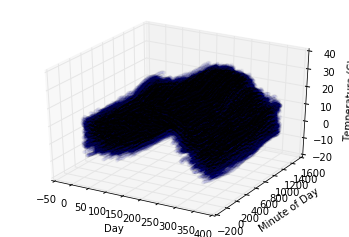

In [89]:
#Make a 3D plot showing temperature as a function of (day, time). Make sure to label your axes!
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(days,minutes,temperatures,cmap='viridis', s=10,alpha=0.01)
ax.set_xlabel('Day')
ax.set_ylabel('Minute of Day')
ax.set_zlabel('Temperature (C)')
plt.show()

In [ ]:
regr = Ridge(alpha=0.0001, fit_intercept=True)
regr.fit(rbf_train, y_train)

In [88]:
def make_surface(days_meshgrid, day_centers, day_sigma, 
                 min_meshgrid, min_centers, min_sigma, ridge):
    expanded_days = np.array(rbf_kernel(days_meshgrid[:,0].reshape(-1, 1), 
                                        day_centers, gamma=1.0/day_sigma))
    
    expanded_mins = np.array(rbf_kernel(min_meshgrid[0].reshape(-1, 1), 
                                        min_centers, gamma=1.0/min_sigma))
    expanded_2D = []
    
    for i in xrange(len(expanded_days)):
        for j in xrange(len(expanded_mins)):
            expanded_2D.append(np.hstack((expanded_days[i], expanded_mins[j])))
    pred = ridge.predict(expanded_2D)
    all_y = pred.reshape(200, 200)
    return all_y

In [91]:
#regression 
n_rbf=1000
sigma=10
center_min = np.linspace(0, 1399, n_rbf).reshape(-1, 1)
center_days = np.linspace(0, 366, n_rbf).reshape(-1, 1)

### Coverting each input dimension with a list of radial basis functions ###
# The function rbf_kernel computes the radial basis function (RBF) kernel between two vectors X,Y: K(x, y) = exp(-gamma ||x-y||^2) 
# (from http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html#sklearn.metrics.pairwise.rbf_kernel and the user guide)
# Calculating RBF Kernels on the entier dataset, test+train
minutes_rbf = rbf_kernel(all_minutes,center_min,gamma=1/sigma)
days_rbf = rbf_kernel(all_days,center_days,gamma=1/sigma)

###  Split Data to Train and Test ###
# find the row of first 2016 entry to split by
split_id = np.where(np.logical_and(df.Date == '2016-01-01 00:00:00' , df.Min == 0.0))[0][0] # that's row 525479 apparently            
# Splitting to test and train sets : either minutes or days
X_train = np.concatenate((minutes_rbf[:split_id],days_rbf[:split_id]),axis=1)   
X_test = np.concatenate((minutes_rbf[split_id:],days_rbf[split_id:]),axis=1)       

#regression on all
regr = Ridge(alpha = alpha_ridge, fit_intercept=False) 
regr.fit(X_train,temp_y_train) 
y_pred_train = regr.predict(X_train)
y_pred_test = regr.predict(X_test) 


NameError: name 'all_minutes' is not defined

NameError: name 'alpha_ridge' is not defined

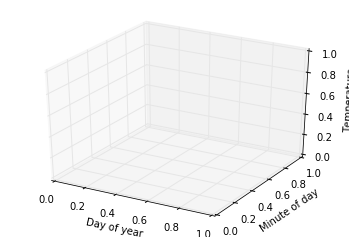

In [87]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

all_days = np.linspace(0.0, 366.0, 365) #setting RBF centers to 365
all_mins = np.linspace(0.0, 1435.0, 365)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel('Day of year') 
ax.set_ylabel('Minute of day')
ax.set_zlabel('Temperature')

m_mesh, d_mesh = np.meshgrid(all_mins, all_days)


Z = make_surface(d_mesh, d_centers, d_sigma, 
                 m_mesh, t_centers, t_sigma, regr)

surface = ax.plot_surface(d_mesh, m_mesh, Z, cmap=cm.plasma)

KeyboardInterrupt: 

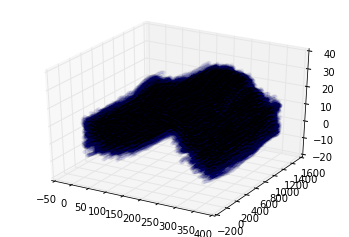

In [81]:
# ColorMap 3D - doesn't load
from matplotlib import cm
#Make a 3D plot showing temperature as a function of (day, time). Make sure to label your axes!
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(days,minutes,temperatures,cmap='viridis', s=10,alpha=0.01)
ax.plot_surface(days, minutes,temperatures, cmap=cm.coolwarm, linewidth=0, antialiased=False, alpha = 0.1, zorder=0)
ax.set_xlabel('Day')
ax.set_ylabel('Minute of Day')
ax.set_zlabel('Temperature (C)')
plt.show()

## Yosemite Village Rain
There is occasionally rain in Yosemite Village. Fortunately the original dataset also includes precipitation.


1. Using logistic regression predict the probability of rain in a given day of the year.
2. What accuracy would a classifier get if it simply predicted “No rain” all the time?
3. Describe your model and data preparation to a level of detail so that another machine learning researcher could reproduce your results.

Submit your code, and results as a pdf produced from a Python Notebook. Include relevant images or plots.


### Process
I'm using logistic regression since it gives us directly "probability" resutls, as P(Y|X), for whatever we insert it. 


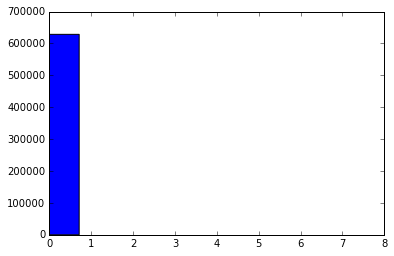

There are 15677 rainy observations out of 629341 observations, percentage is 0.0249101838272
(Q2:) Therefore, an accuracy for a classifier that always predicts "NO" would be: 99.9750898162%


In [50]:
# I'll define "Rain" as in percipitation is any value above 0 (since there are not that many anyway)
plt.hist(df.Rain)
plt.show()
print("There are {} rainy observations out of {} observations, percentage is {}".format(len(df.Rain[df.Rain>0]), len(df.Rain), float(len(df.Rain[df.Rain>0]))/ len(df.Rain)))

print('(Q2:) Therefore, an accuracy for a classifier that always predicts "NO" would be: {}%'.format(100.0-(float(len(df.Rain[df.Rain>0]))/ len(df.Rain))))

In [58]:
## Convert Rain to binary classification
df['RainBinary'] = (df['Rain'] > 0)
df.head()

,Date,Yr,DayInt,Min,HHmm,Temp,Rain,RainBinary
0,2011-01-01,2011,1,5.0,5.0,-6.4,0.0,False
1,2011-01-01,2011,1,10.0,10.0,-6.5,0.0,False
2,2011-01-01,2011,1,15.0,15.0,-6.5,0.0,False
3,2011-01-01,2011,1,20.0,20.0,-6.5,0.0,False
4,2011-01-01,2011,1,25.0,25.0,-6.7,0.0,False


In [63]:
X = df['Day'].values
y = df['RainBinary'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)

X_train = X_train.reshape(-1,1)
X_test = X_test.reshape(-1,1)


logreg = LogisticRegression()
logreg.fit(X_train,y_train)
pred = logreg.predict(X_test)

print "R^2 score for test set:", logreg.score(X_test,y_test)

R^2 score for test set: 0.974525855494




## Results
Results show supposedly great accuracy of 0.974525855494. However, as we saw before, there are only 0.02% of observations with Rain in them, and the Naive classifier that would classify everything as 'No' would have abotu the same or even marginally better accuracy - of 0.975 vs 0.974. 


In [ ]:
df_grouped = df.groupby(['Year','Day'], as_index=False)['RainBinary'].agg(['id','max'])

#### Remark
I wasn't sure what was meant by predicting for each day. I took it as a simpler case of rpredicting per a given moment; however, maybe the intention was predicting per DAY. In that case, I would need to group by day, take the maximum of (Binary Rain Classification), then model per that. I tried this in many ways but it didn't work, and I'm not feeling good enough to keep trying, but hope to revisit this kind of transformaiton in the future. 

For example:
df_grouped = df.groupby(['Year','Day'], as_index=False)['RainBinary'].agg(['id','max'])